1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [1]:
from gui.utils import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2')

bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-04"')

neo_all = pd.read_csv('./data/takeoff-merged-all-neo.csv', parse_dates=['reportts'], low_memory=False)

In [2]:
grouped = neo_all.groupby(['acnum', 'pos'])

for group_name, group_df in grouped:
    print("Group:", group_name, group_df.shape)

Group: ('VP-BWB', 1) (254, 206)
Group: ('VP-BWB', 2) (254, 206)
Group: ('VP-BWM', 1) (279, 206)
Group: ('VP-BWM', 2) (279, 206)
Group: ('VP-BWN', 1) (201, 206)
Group: ('VP-BWN', 2) (201, 206)
Group: ('VQ-BCR', 1) (524, 206)
Group: ('VQ-BCR', 2) (556, 206)
Group: ('VQ-BDQ', 1) (395, 206)
Group: ('VQ-BDU', 1) (716, 206)
Group: ('VQ-BDU', 2) (1225, 206)
Group: ('VQ-BGU', 1) (786, 206)
Group: ('VQ-BGU', 2) (783, 206)
Group: ('VQ-BRI', 1) (47, 206)
Group: ('VQ-BRI', 2) (366, 206)


In [3]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202404192324.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).sort_values('reportts', ignore_index=True)

print("Total acms takeoff reports: ", acms_full.shape)

Total acms takeoff reports:  (253920, 204)


In [4]:
alpha = 0.5
alpha_2 = 0.884

In [5]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  mach_k = 1.0 + 0.2 * (data['mn_peak'] ** 2)
  theta = (data[theta_param] + 273.16) / (288.16 * mach_k)
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (0 + theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
import numpy as np

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_config = [(0, 20_000)],
            theta_alpha = alpha_2,
            acms_data = None,
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_config = alt_config
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05
        self.acms_data = acms_data

    def _config_to_hash (self, acnum: str, pos: int, bleed: tuple[bool], alt: tuple[int] = (0, 0)):
        if len(bleed) == 0:
            return 0
        a = map(int, bleed)
        alt_lo, alt_hi = alt
        return f'{acnum}_{pos}_' + ''.join(map(str, a)) + str(alt_lo)

    def _get_bleed_filter_index(self, X, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        assert len(bleed_conf) == len(self.bleed_config)
        index = X.iloc[:, 0] == X.iloc[:, 0]

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == bleed_conf[i])

        alt_lo, alt_hi = alt_conf
        index = index & (X['alt'] >= alt_lo) & (X['alt'] < alt_hi)

        return index
    
    def _fit_single_engine(self, X, y, acnum, pos):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'

        egt_delta = pd.DataFrame(index=X.index.copy(), columns=['base'])

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf, yf = X[index], y[index]

                if self.acms_data is not None: 
                    acms = theta_correct(self.acms_data.copy(), self.x_param, self.y_param, self.theta_param, self.theta_alpha)
                    baseline = train_engine_baseline(acms, x_param_k, y_param_k)
                else:
                    baseline = train_engine_baseline(Xf, x_param_k, y_param_k)

                egtm_base = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                egt_delta.loc[index, 'base'] = egtm_base

                n = self._config_to_hash(acnum, pos, bleed_comb, alt_split)
                self.baselines[n] = baseline

        return egt_delta

    def _predict_single_engine(self, X, acnum, pos):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                n = self._config_to_hash(acnum, pos, bleed_comb, alt_split)
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]
                baseline = self.baselines[n]

                egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                pred_conf = self.ensemble[f'{acnum}_{pos}'].predict(pd.DataFrame(egtm))
                pred.loc[index, 'pred'] = pred_conf
        
        return pred['pred']


    def fit(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()

        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
        Xk, y = Xk[X_filter], y[X_filter]

        """
        *separate* baseline for each bleed config
        later try single baseline for engine 
        but fit linreg to each bleed conf separately
        """

        self.baselines = dict()
        self.ensemble = dict()

        data = pd.concat([Xk, y], axis=1)

        grouped = data.groupby(['acnum', 'pos'])

        for group, X_engine in grouped:
            acnum, pos = group

            y_eng = X_engine['egtm']
            X_eng = X_engine.drop(columns=['egtm'])

            egt_delta = self._fit_single_engine(X_eng, y_eng, acnum, pos)

            linreg = LinearRegression()
            smooth_base_egtm = pd.DataFrame(smooth(egt_delta['base'], self.smooth_factor), columns=[f'{self.y_param}_k'])
            linreg.fit(smooth_base_egtm, y_eng)
            self.ensemble[f'{acnum}_{pos}'] = linreg

        return self
        
    def predict(self, X):
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        grouped = Xk.groupby(['acnum', 'pos'])

        for group, _ in grouped:
            acnum, pos = group
            index = (Xk['acnum'] == acnum) & (Xk['pos'] == pos)
            X_engine = Xk[index]
            pred_engine = self._predict_single_engine(X_engine, acnum, pos)
            pred.loc[index, 'pred'] = pred_engine

        return pred['pred']
    
    def score(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        Xf, yf = X[X_filter], y[X_filter]

        y_pred = self.predict(Xf.copy())
        return r2_score(yf, smooth(y_pred, self.smooth_factor))


In [7]:
def take_early_cycles(X, n_start = 0, n_end = 100):
  res = []
  grouped = X.groupby(['acnum', 'pos'])

  for _, group in grouped:
    res.append(group[n_start:n_end])

  return pd.concat(res)

R2 score =  0.9353659282131018


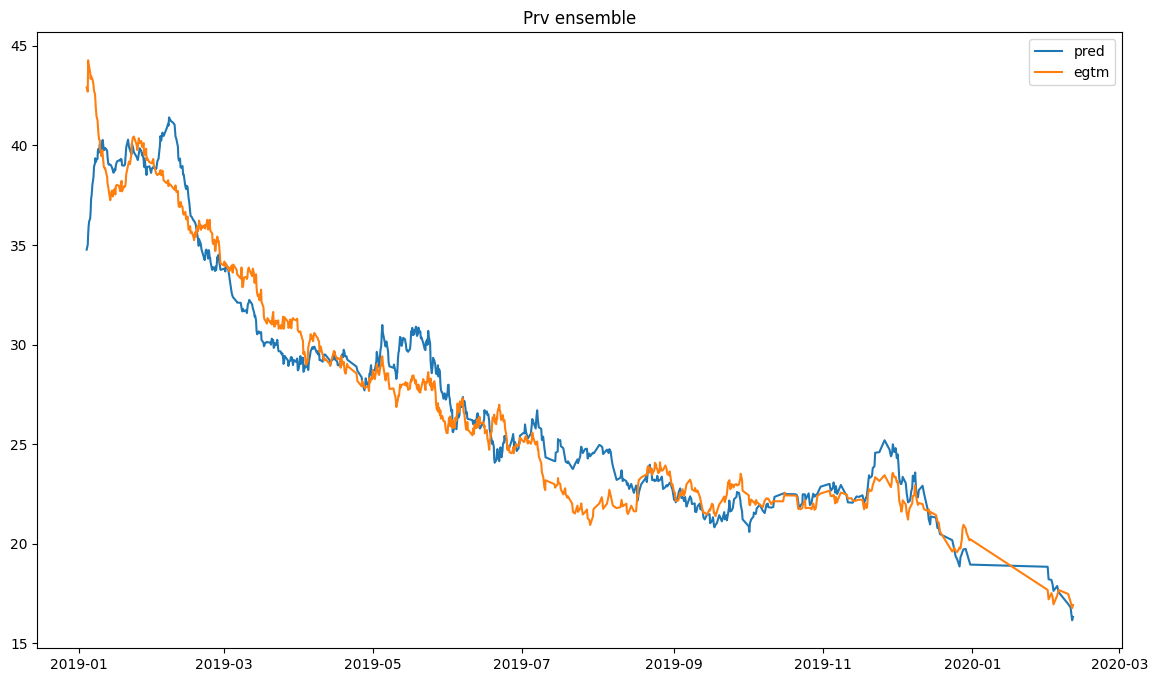

In [44]:
x_param='n1a_peak'
y_param='egt_peak'
theta_param='t2_peak'

model = EGTMarginRegressor(
  bleed_config=['prv'], 
  alt_config=[(0, 3400), (3400, 20_000)],
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param
)

bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()

train = take_early_cycles(bgu, 0, 400)
X = train.drop(columns=['egtm'])
y = train['egtm']

model.fit(X, y)

pred = model.predict(bgu)

print("R2 score = ", model.score(bgu, bgu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
# plt.scatter(bgu['reportts'], smooth(pred['pred'], 0.05), c=bgu['egt'], cmap='cool', s=2)
plt.plot(bgu['reportts'], smooth(pred, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

In [59]:
model = EGTMarginRegressor(
  bleed_config=['prv'], 
  # alt_config=[(0, 3400), (3400, 20_000)],
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param
)

neo = neo_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()

train = take_early_cycles(neo, 0, 200)
X = train.drop(columns=['egtm'])
y = train['egtm']

model.fit(X, y)

print("R2 score = ", model.score(neo, neo['egtm']))

neo_bcr = neo.query('acnum == "VQ-BRI" and pos == 2').copy()
train_bcr = train.query('acnum == "VQ-BRI" and pos == 2').copy()
pred = model.predict(neo_bcr)

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(neo_bcr['reportts'], smooth(pred, 0.05))
plt.plot(neo_bcr['reportts'], neo_bcr['egtm'])
plt.plot(train_bcr['reportts'], train_bcr['egtm'])
plt.scatter(neo_bcr['reportts'], pred, s=1)
plt.legend(['pred', 'egtm_test', 'egtm_train'])
plt.show()

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [51]:
model.ensemble['VP-BWB_1'].coef_, model.ensemble['VP-BWB_1'].intercept_

(array([1.1228012]), 86.08175640886725)

In [54]:
model.ensemble['VP-BWM_2'].coef_, model.ensemble['VP-BWM_2'].intercept_

(array([0.88004231]), 102.35707016127274)

ACMS Baselines:

In [7]:
bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()
acms_bgu = acms_full.query(f"acnum == 'VQ-BGU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()
acms_bdu = acms_full.query(f"acnum == 'VQ-BDU' and pos == 2 and n1a_peak > 0 and egt_peak > 0 and tat_peak > -100").copy()

In [8]:
model.ensemble.coef_, model.ensemble.intercept_

(array([1.3774313]), -16.026504757493342)

In [9]:
acms_bgu.shape

(3287, 204)

/tmp/ipykernel_1291767/682793783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (0 + theta ** alpha2)
/tmp/ipykernel_1291767/682793783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)


Split size:  (True,) 343
Split size:  (False,) 57
R2 score =  0.9103522386232006


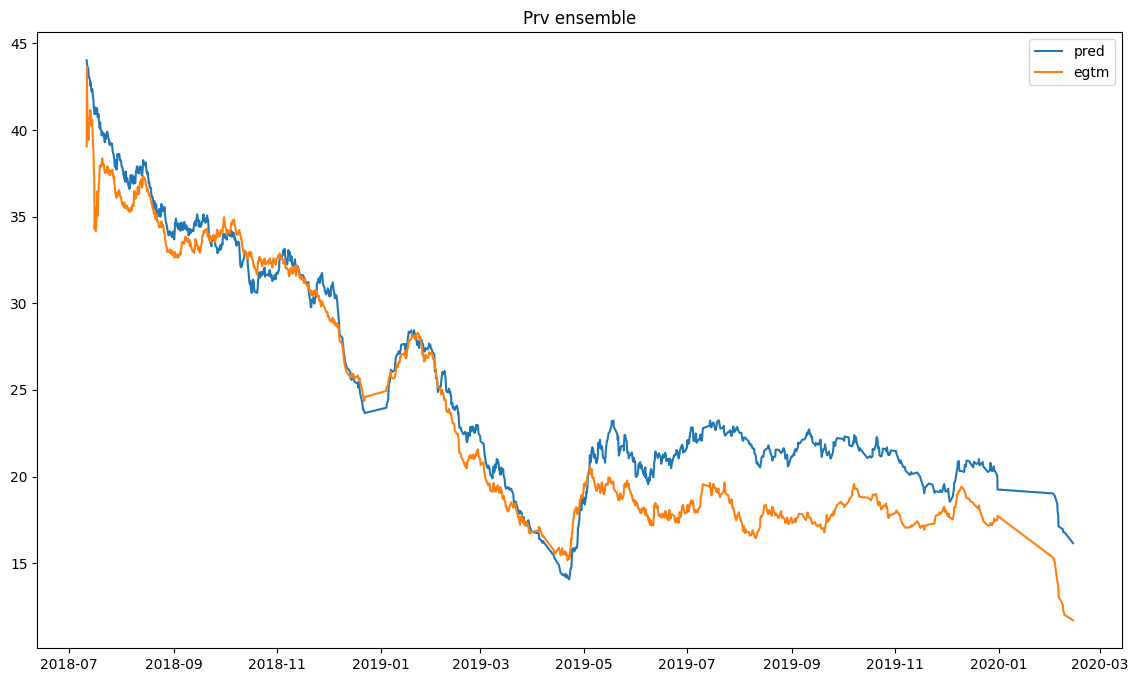

In [10]:
model = EGTMarginRegressor(
  acms_data=acms_bdu[:800], 
  bleed_config=['prv'], 
  x_param='n1a_peak', 
  y_param='egt_peak',
)

train = bdu[200:600]
X = train
y = train['egtm']

model.fit(X, y)

pred = model.predict(bdu)

print("R2 score = ", model.score(bdu, bdu['egtm']))

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.plot(bdu['reportts'], smooth(pred['pred'], 0.05))
plt.plot(bdu['reportts'], bdu['egtm'])
plt.legend(['pred', 'egtm'])
plt.show()

### 1. Gridsearch of x/y/theta variants

Use proper gridsearch utilizing new regressor class

In [11]:
from sklearn.model_selection import GridSearchCV

best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

x_variants = [\
  'n1', 'n1a', 'n1com', 'n1c2', 'n2a', 'n2c5',
  'n2p', 'nf', 'n1_peak', 'n1msa', 'n1p',
  'n1a_peak', 'n1c2_peak', 'n1com_peak', 
  'n1max', 'n1max_peak', 'n2a_peak', 'nf_peak']

y_variants = ['egt', 'egt_peak', 'egtb']

theta_variants = ['oat', 'oat_peak', 't14', 't2', 't25', 't2_peak', 'tat', 'tat_rtd', 'tn', 'tat_peak']

hall_of_fame = []

tat_peak = правильный

In [ ]:
model = EGTMarginRegressor()

train = bgu.copy()
X = train.drop(columns=['egtm'])
y = train['egtm']


grid = GridSearchCV(model, {
  'x_param': x_variants,
  'y_param': y_variants,
  'theta_param': theta_variants
}, n_jobs=-1)

grid.fit(X, y)

In [13]:
grid.best_params_

{'theta_param': 't2', 'x_param': 'n1', 'y_param': 'egt'}

In [14]:
cv_results = grid.cv_results_

params = cv_results['params']
mean_scores = cv_results['mean_test_score']

param_scores = list(zip(params, mean_scores))

# Sort parameter combinations based on scores
sorted_param_scores = sorted(param_scores, key=lambda x: x[1], reverse=True)

# Get the top n parameter combinations
n = 5  # Specify the number of top parameter combinations you want
top_n_param_combinations = sorted_param_scores[:n]

# Print the top n parameter combinations
print(f"Top {n} parameter combinations:")
for i, (params, score) in enumerate(top_n_param_combinations, start=1):
    print(f"{i}. Parameters: {params}, Mean Test Score: {score}")

Top 5 parameter combinations:
1. Parameters: {'theta_param': 't2', 'x_param': 'n1', 'y_param': 'egt'}, Mean Test Score: -1.1280445361125069
2. Parameters: {'theta_param': 'oat', 'x_param': 'nf', 'y_param': 'egt'}, Mean Test Score: -1.166528498321337
3. Parameters: {'theta_param': 't2', 'x_param': 'nf', 'y_param': 'egt'}, Mean Test Score: -1.1695969205695327
4. Parameters: {'theta_param': 'oat', 'x_param': 'n1', 'y_param': 'egt'}, Mean Test Score: -1.1938117277852076
5. Parameters: {'theta_param': 'oat', 'x_param': 'n1a', 'y_param': 'egt'}, Mean Test Score: -1.2234371005190883


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 250
      baseline = train_engine_baseline(bdu[50:250], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [16]:
pd.DataFrame(hall_of_fame).sort_values('rmse')[:10]

,x_param,y_param,theta_param,rmse
492,n2a_peak,egt_peak,t14,0.830892
495,n2a_peak,egt_peak,t2_peak,0.854996
499,n2a_peak,egt_peak,tat_peak,0.865870
491,n2a_peak,egt_peak,oat_peak,0.866610
496,n2a_peak,egt_peak,tat,0.950374
120,n2a,egt,oat,1.026282
127,n2a,egt,tat_rtd,1.037091
121,n2a,egt,oat_peak,1.062510
123,n2a,egt,t2,1.066969
129,n2a,egt,tat_peak,1.082192


#### Plot best result: 

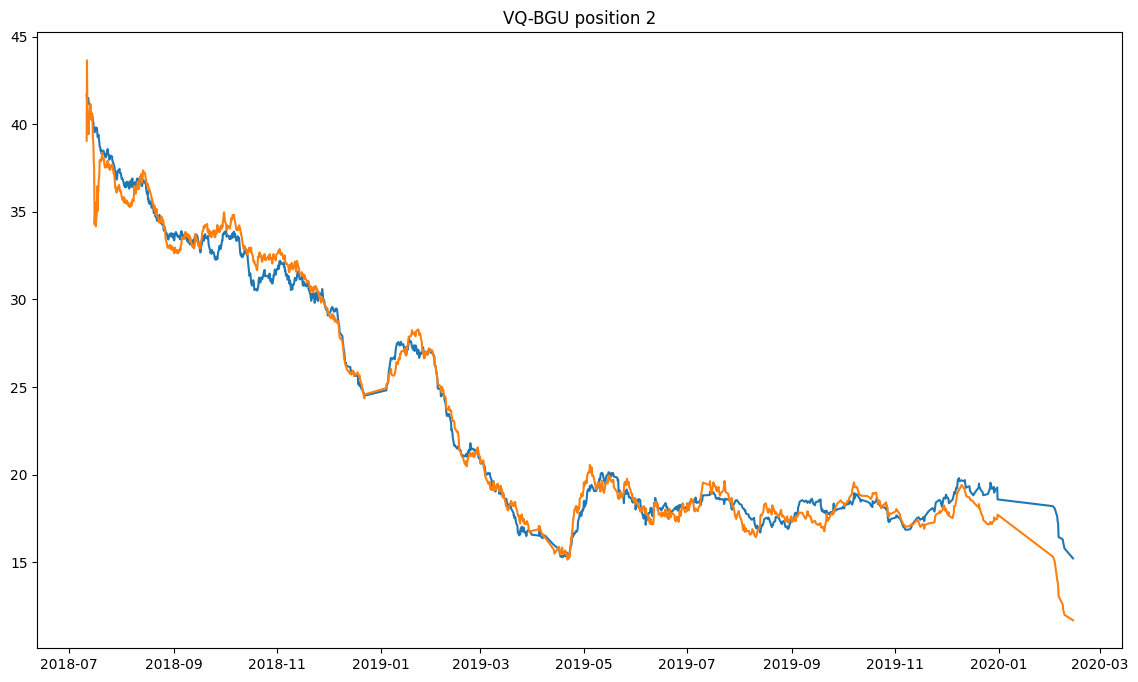

In [17]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

### Finetune coefficient for theta corrections

In [18]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 't14')

In [19]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9000, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8825 0.8315689377080188


**Result For VQ-BDU pos 2:**

```
- alpha_2 ~ 0.869
- x_param = n2a_peak
- y_param = egt_peak	
- theta_param = tat
```

For VQ-BGU results are inconsistent; We try to plot deltas applying corrections same as for VQ-BDU

In [20]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-01"')
bgu_all.shape

(814, 212)

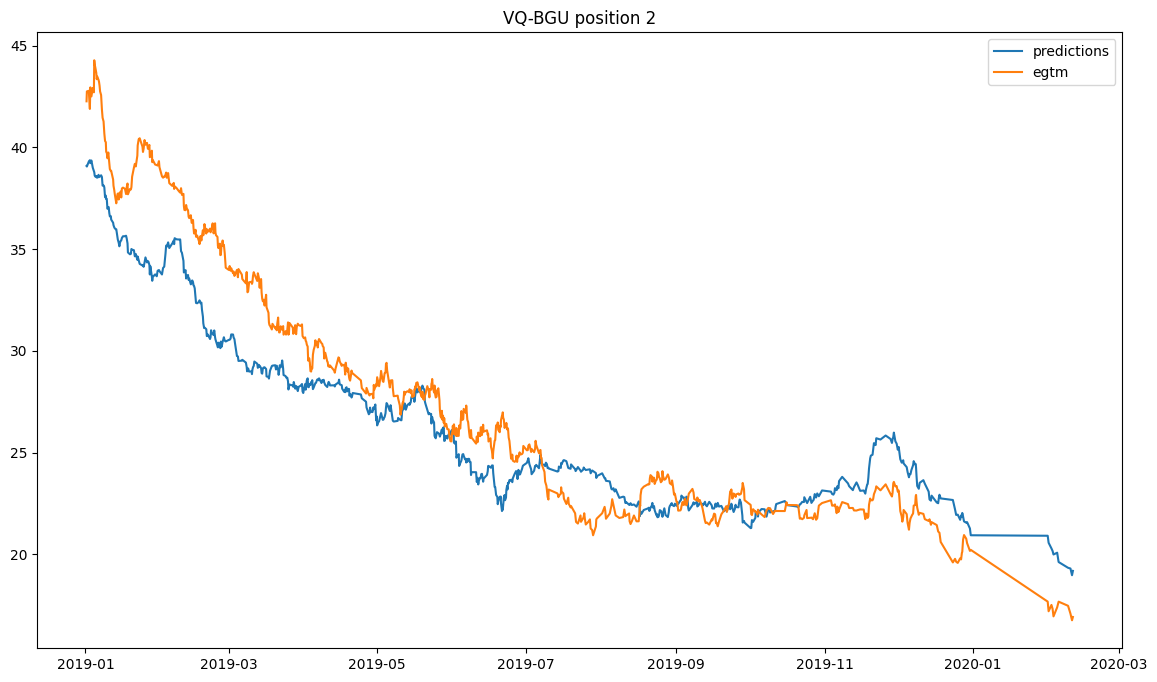

In [21]:
x_param = "n2a_peak"
y_param = "egt_peak"
theta_param = "tat_peak"

bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
bgu = theta_correct(bgu, x_param, y_param, theta_param)
assert bgu.shape[0] >= 100
baseline = train_engine_baseline(bgu[:100], x_param_k, y_param_k)
egtm = compute_egtm(bgu, baseline, x_param_k, y_param_k)

X = pd.DataFrame(smooth(egtm, 0.05))
lin_model = LinearRegression()
lin_model.fit(X[:100], y=bgu['egtm'][:100])

pred = lin_model.predict(X)

rmse = root_mean_squared_error(bgu['egtm'], pred)

# bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
# plt.plot(bgu['reportts'], pred)
plt.plot(bgu['reportts'], smooth(0.8 * egtm + 7.4, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['predictions', 'egtm'])
plt.show()